In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D

path = '../output_data/test_output/'

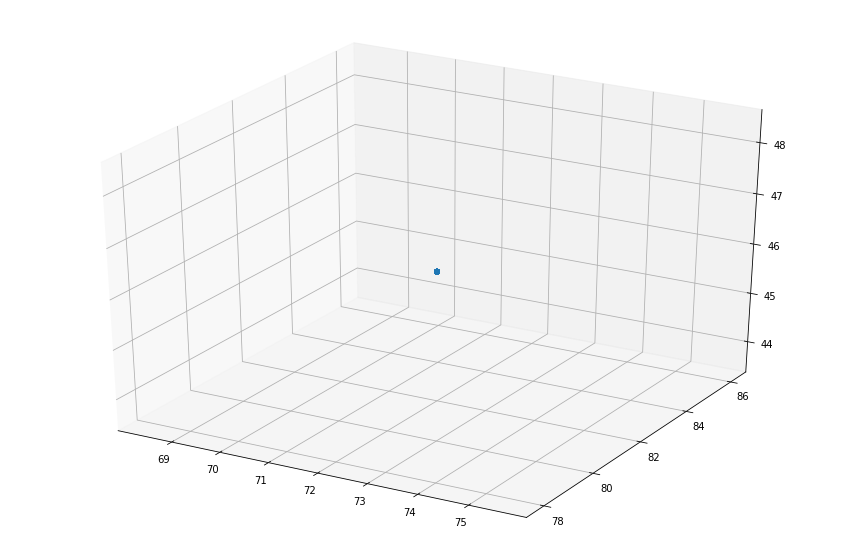

In [63]:
with pd.HDFStore(path + 'X0c.h5') as store:
    opd = store.select('dat_0')
opd.index = opd.index.droplevel(['eps', 'phi', 'test'])
opinions = opd.xs(level=1, key='opinions')
dfN = opinions
dfN_vis = pd.DataFrame(index=dfN.index)
dfN_vis['x'] = dfN['O1'] + dfN['O2'] + dfN['O3']
dfN_vis['y'] = dfN['O4'] + dfN['O5'] + dfN['O6']
dfN_vis['z'] = dfN['O7'] + dfN['O8']

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dfN_vis[['x']], ys=dfN_vis[['y']], zs=dfN_vis['z'])

In [64]:
with pd.HDFStore(path + 'X0c.h5') as store:
    trj = store.select('dat_1')
trj.index = trj.index.droplevel(['eps', 'phi', 'test'])
trj.head()

time           wage       r_c       r_d   r_c_dot   r_d_dot  \
sample tstep                                                                
2      0.00   0.00  104501.806253  0.062928  0.074537  0.000000  0.000000   
       0.05   0.05  104496.876043  0.063013  0.074533  0.001407 -0.000111   
       0.10   0.10  104492.599941  0.063098  0.074528  0.001492 -0.000098   
       0.15   0.15  104488.259149  0.063183  0.074522  0.001738 -0.000107   
       0.20   0.20  104483.927091  0.063264  0.074518  0.001353 -0.000080   

                       K_c           K_d           P_c           P_d  \
sample tstep                                                           
2      0.00   3.119346e+14  2.041850e+15  3.756788e+08  2.912742e+09   
       0.05   3.123115e+14  2.041183e+15  3.766545e+08  2.911766e+09   
       0.10   3.123755e+14  2.040822e+15  3.772556e+08  2.911165e+09   
       0.15   3.124711e+14  2.040432e+15  3.778946e+08  2.910526e+09   
       0.20   3.126392e+14  2.039981e+15  3.786019e+08  2.909819e+09   

                ...      c[0]   d[2, 3]  d[3, 2]  d[4, 2]   d[4, 3]  d[4, 1]  \
sample tstep    ...                                                            
2      0.00     ...       0.0  0.000000      0.0    0.000  0.000000     0.00   
       0.05     ...       0.0  0.140000      0.0    0.150  0.135000     0.12   
       0.10     ...       0.0  0.140000      0.0    0.145  0.135000     0.12   
       0.15     ...       0.0  0.140557      0.0    0.145  0.134443     0.12   
       0.20     ...       0.0  0.140000      0.0    0.150  0.130000     0.12   

              d[4, 0]  d[1]   d[0]  sample_id  
sample tstep                                   
2      0.00     0.000   0.0  0.000        NaN  
       0.05     0.160   0.0  0.155        NaN  
       0.10     0.160   0.0  0.150        NaN  
       0.15     0.160   0.0  0.150        NaN  
       0.20     0.155   0.0  0.150        NaN  

[5 rows x 50 columns]

In [65]:
cond = pd.DataFrame(index=trj.index)
cond['a'] = trj['K_c']/trj['K_d'] - 0.15276374882897656
cond['b'] = trj['i_c']
cond['c'] = trj['r_c']

# cond['d'] = np.sqrt((cond['a'])**2)
# cond['d'].unstack('sample').loc[:9].sum(axis=0)

In [66]:
t_max=9.

# calculate point distance
cond['d'] = np.sqrt((cond['a'])**2)

# sum over point distance for each trajectory
dfN['distance'] = cond['d'].unstack('sample').loc[:t_max].sum(axis=0)

# map distances to interval (0,1]
dfN['inv_distance'] = 1./(1. + dfN['distance'])

# use 1/distance as weight
dfN['weight'] = 1/cond['d'].unstack('sample').loc[:t_max].sum(axis=0)
dfN['weight'] = dfN['weight']/sum(dfN['weight'].values)

for s in dfN.index.values:
    cond.loc[s, 'inv_distance'] = dfN.loc[s, 'inv_distance']
dfN['weight'].sum()
dfN.head()

,O1,O2,O3,O4,O5,O6,O7,O8,sample_id,distance,inv_distance,weight
sample,,,,,,,,,,,,
2,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN,3.332128,0.230833,0.002340
1,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN,0.957800,0.510778,0.008141
0,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN,0.799072,0.555842,0.009758
3,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN,2.582576,0.279129,0.003019
5,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN,0.981986,0.504545,0.007940


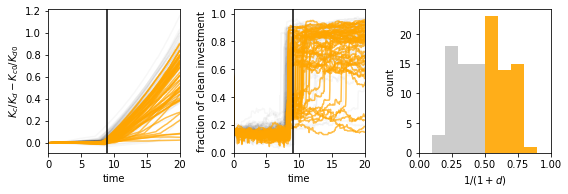

In [67]:
from collections import Counter
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.8))

def plot_cond(df, c, ax, t_max, thresh=0.5):
    tmp = df
    tmp1 = tmp[[c]].loc[tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[tmp['inv_distance']>thresh]
    tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'])
    tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.7, color=['orange'])
    
thresh=0.5

plot_cond(cond, 'a', axes[0], 20, thresh=thresh)
plot_cond(cond, 'b', axes[1], 20, thresh=thresh)

dfN['inv_distance'].loc[dfN['inv_distance']>thresh].plot.hist(ax=axes[2], color=['orange'], alpha=0.9, bins=0.1*np.arange(5,11))
dfN['inv_distance'].loc[dfN['inv_distance']<thresh].plot.hist(ax=axes[2], color=['k'], alpha=0.2, bins=0.1*np.arange(0,6))

# hist_data = pd.DataFrame(index=dfN.index)
# hist_data.loc[dfN['inv_distance']<thresh, 'classification'] = 'below'
# hist_data.loc[dfN['inv_distance']>thresh, 'classification'] = 'above'

# cnt = Counter(hist_data['classification'])

# keys1 = ['below', 'above']
# keys2 = ['above', 'below']
# keys=keys2

# axes[2].bar(keys, [cnt[k] for k in keys])

# indexes = np.arange(len(keys))

# # add labels
# plt.xticks(indexes, keys)

for ax in axes[:2]:
    ax.set_xlim([0,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$K_c/K_d - K_{c0}/K_{d0}$')
axes[1].set_ylabel('fraction of clean investment')
axes[1].set_ylim((0,1.03))
axes[2].set_ylabel('count')
axes[2].set_xlabel(r'$1/(1+d)$')
axes[2].set_xlim([0,1])

fig.tight_layout()
fig.savefig('initial_condition_fitted.pdf')

In [68]:
oNames = [f'O{i+1}' for i in range(8)]

dfN_norm = pd.DataFrame(index=dfN.index, columns=dfN.columns)

for i in range(len(dfN)):
    dfN_norm.loc[i, oNames] = dfN.loc[i, oNames] * dfN['weight'][i]
dfN_norm['weight'] = dfN['weight']
print([x for x in dfN_norm.sum()])
print(sum([round(x) for x in dfN_norm[oNames].sum()]))

[27.999999999999993, 13.999999999999996, 30.000000000000007, 25.999999999999996, 23.999999999999993, 32.00000000000001, 13.999999999999996, 32.00000000000001, 0.0, 0.0, 0.0, 1.0000000000000002]
200


In [ ]:
sum([15, 8, 12, 12, 14, 17, 7, 16])

In [24]:
# initial opinions:
fitted_opinions_distribution = [15, 8, 12, 12, 14, 17, 7, 16]
x = [2 * x for x in fitted_opinions_distribution]
opinions = []

for i, xi in enumerate(x):
    opinions += int(np.round(xi)) * [i]
np.random.shuffle(opinions)
# as the fitted distribution has one count to many, I have to leave two out
# here.
opinions = opinions[:-2]

In [25]:
from collections import Counter
cnt = Counter(opinions)
for i in range(7):
    print(i, cnt[i])
print(cnt.keys())
print(cnt.values())

0 29
1 16
2 24
3 24
4 27
5 34
6 14
dict_keys([4, 5, 2, 0, 7, 3, 1, 6])
dict_values([27, 34, 24, 29, 32, 24, 16, 14])


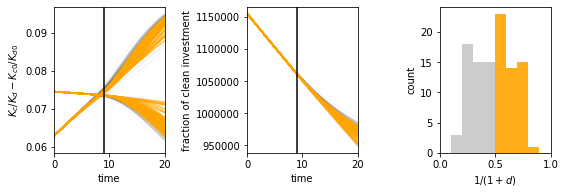

In [72]:
from collections import Counter
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.8))

def plot_cond(df, c, ax, t_max, thresh=0.5, style=['-']):
    tmp = df
    tmp1 = tmp[[c]].loc[tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[tmp['inv_distance']>thresh]
    tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'], style=style)
    tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.7, color=['orange'], style=style)
    
thresh=0.5

trj['inv_distance'] = cond['inv_distance']

plot_cond(trj, 'r_c', axes[0], 100, thresh=thresh)
plot_cond(trj, 'r_d', axes[0], 100, thresh=thresh, style=['--'])
plot_cond(trj, 'G', axes[1], 100, thresh=thresh)

dfN['inv_distance'].loc[dfN['inv_distance']>thresh].plot.hist(ax=axes[2], color=['orange'], alpha=0.9, bins=0.1*np.arange(5,11))
dfN['inv_distance'].loc[dfN['inv_distance']<thresh].plot.hist(ax=axes[2], color=['k'], alpha=0.2, bins=0.1*np.arange(0,6))

for ax in axes[:2]:
    ax.set_xlim([0,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$K_c/K_d - K_{c0}/K_{d0}$')
axes[1].set_ylabel('fraction of clean investment')
#axes[1].set_ylim((0,1.03))
axes[2].set_ylabel('count')
axes[2].set_xlabel(r'$1/(1+d)$')
axes[2].set_xlim([0,1])

fig.tight_layout()
fig.savefig('initial_condition_fitted.pdf')